In [1]:
import numpy as np
import sys
import scipy.io as sio  # For reading the matlab .mat format
from scipy.stats import zscore, entropy
from scipy.special import binom as binomial
import collections
import pickle as pk
import itertools
import persim
import numpy as np
import pandas as pd
import iisignature as iis
import gudhi
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
import time
import matplotlib.pyplot as plt
import random
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from scipy.stats import ttest_ind

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# 160 ARE ROI

def load_data_mat(path_single_file):
    file_to_open = path_single_file
    data = sio.loadmat(file_to_open)
    key_data = list(data.keys())[-1]
    data = data[key_data]
    return(data)

In [3]:
def lead_matrix_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,2)
    S=sig[N:].reshape(N,N)
    L=(S-S.T)/2
    return L

def lead_tensor_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,3)
    l=N+N*N
    S=sig[l:].reshape(N,N,N)
    T=(S-S.transpose((0,2,1))+S.transpose((2,0,1))-S.transpose((2,1,0))+S.transpose((1,2,0))-S.transpose((1,0,2)))/6
    return T


In [4]:
def rev_directed(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    for i in range(l):
        for j in range(l):
            if L[j,i]<0:
                L[j,i]=0
                
    ADM=a*np.ones((l,l))-a*np.identity(l)-L            
    dgm=FlagserPersistence().fit_transform([ADM])
    return dgm

def rev_undirected(L):
    l=L.shape[0]
    a=np.max(np.abs(L))
    ADM=a*np.ones((l,l))-a*np.identity(l)-np.abs(L)
    VR= VietorisRipsPersistence(metric="precomputed")
    dgm= VR.fit_transform([ADM])
    return dgm

In [8]:
def create_filtration_2(Lead_matrix, Lead_tensor,indifferent_value):
    

    # Creating the list of simplicial complex with all the edges and triangles
    sc=gudhi.SimplexTree()
    list_simplices = []
    N=Lead_matrix.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(Lead_matrix[i,j])<indifferent_value:
                Lead_matrix[i,j]=0
            for k in range(N):
                if np.abs(Lead_tensor[i,j,k])<indifferent_value:
                    Lead_tensor[i,j,k]=0

        

        # Selecting the extremal weight between edges and triplets. It will be assigned to all the nodes (i.e. nodes enter at the same instant)
    m_weight = np.max([np.ceil(np.max(np.abs(Lead_matrix))), np.ceil(np.max(np.abs(Lead_tensor)))])
    # Adding all the nodes from the beginning with the same weights
    for i in range(N):
        list_simplices.append(([i], m_weight))

        # Adding the edges:
        # Also, modify the signs of the weights to correct the z-score so that: if the edge signal is fully coherent, then assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            if (not i==j):
                weight=np.abs(Lead_matrix[i,j])
                list_simplices.append(([i,j], weight))

        # Adding the triplets
        # Here I modify the signs of the weights, if it is fully coherent I assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (i==j)) and (not(j==k)) and (not(i==k))):
                    weight=np.abs(Lead_tensor[i,j,k])
                    list_simplices.append(([i,j,k], weight))

    sorted_simplices = sorted(list_simplices, key=lambda x: x[1], reverse=True)

        # Remove the violations
    list_violating_triangles = []
    set_simplices = set()
    counter = 0
    triangles_count = 0
    violation_triangles = 0
    violation_triangles_negativeterms = 0

        # Loop over the sorted simplices, and flippling the sign of all the weights (so that the points in the persistence diagram are above the diagonal)
    for index, i in enumerate(sorted_simplices):
        simplices, weight = i

            # If the current simplex is an edge or a node, then I will immediately include it
        if len(simplices) <= 2:
            sc.insert(simplices, -weight)
            set_simplices.add(tuple(simplices))
            counter += 1
        else:
        # If the current simplex is a triplet, I check whether all the sub-simplices have been included.
            flag = 0
            n0=simplices[0]
            n1=simplices[1]        
            n2=simplices[2]
            if (n0,n1) in set_simplices:
                flag=flag+1
            if (n1,n2) in set_simplices:
                flag=flag+1
            if (n0,n2) in set_simplices:
                flag=flag+1

                # If all the sub-simplices already belong to the set, then I add it in the filtration
            if flag == 3:
                set_simplices.add(tuple(simplices))
                sc.insert(simplices, -weight)
                counter += 1
                triangles_count += 1
            else:
                violation_triangles += 1
                list_violating_triangles.append((simplices, np.abs(weight), 3 - flag))

# Fraction of positive triangle discarderd (a.k.a. the hyper coherence)
    hyper_coherence = (1.0 * violation_triangles) /(triangles_count + violation_triangles)
        
    return(sc, list_violating_triangles,hyper_coherence)




def create_diagram_directly_3(mv_time_series, indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration_2(L,T,indifferent_value)
    sc=f[0]
    hyp=f[2]
    dgm=sc.persistence()
    return dgm,hyp


def entropy_gu_ad(dgm):
    total_0=0
    total_1=0
    l_0=[]
    l_1=[]
    l=len(dgm)
    for i in range(l):
        if dgm[i][0]==1:
            if (not (dgm[i][1][1]==np.inf)):
                length=dgm[i][1][1]-dgm[i][1][0]
                total_1=total_1+length
                l_1.append(length)
        if dgm[i][0]==0:
            if (not (dgm[i][1][1]==np.inf)):
                length=dgm[i][1][1]-dgm[i][1][0]
                total_0=total_0+length
                l_0.append(length)

    log_l_1=np.log(np.array(l_1)/total_1)
    log_l_0=np.log(np.array(l_0)/total_0)
    prod_1=log_l_1*(np.array(l_1)/total_1)
    prod_0=log_l_0*(np.array(l_0)/total_0)
    S_1=-np.sum(prod_1)
    S_0=-np.sum(prod_0)
    return S_0,S_1

def hyper_coherence(mv_time_series,indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration_2(L,T,indifferent_value)
    hyp=f[2]
    return hyp



def hyper_vector(time_series,indifference_value,length):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    hyp_ts=[]
    for i in range(1,length+1):
        sub_ts=time_series[:np.int64(h)*i,:]
        hyp=hyper_coherence(sub_ts,indifference_value)
        hyp_ts.append(hyp)
    return hyp_ts

In [9]:
# parameters
indifference_value=0.05
length=100

In [ ]:
# No Zscore

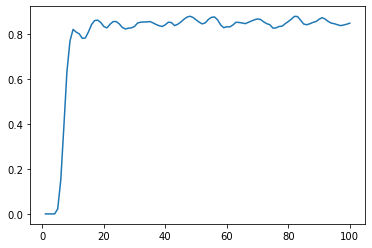

In [10]:
data=load_data_mat("Data/destrieux_timecourse/rTLE/sub-epi20100305/timeseries_regr_wgm_globmean_filt0009008.mat")
time_series=data.transpose()[:150,:]
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

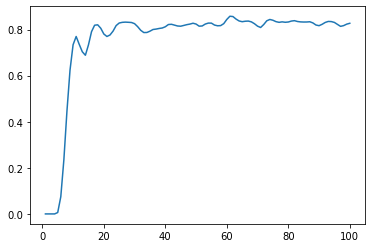

In [11]:
data=load_data_mat(f"Data/destrieux_timecourse/controls/sub-ctr20190720-EEGfMRI/timeseries_regr_wgm_globmean_filt0009008.mat")
time_series=data.transpose()[:150,:]
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

In [12]:
# Zscore

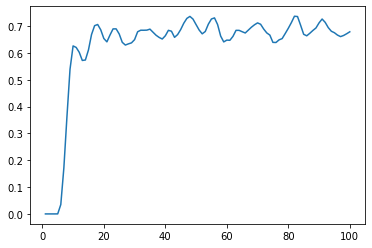

In [13]:
data=load_data_mat("Data/destrieux_timecourse/rTLE/sub-epi20100305/timeseries_regr_wgm_globmean_filt0009008.mat")
tsr=data.transpose()[:150,:]
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()

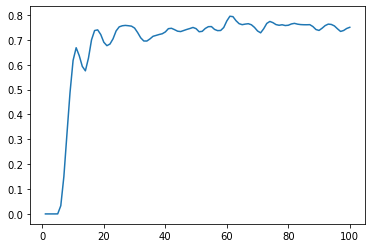

In [14]:
data=load_data_mat(f"Data/destrieux_timecourse/controls/sub-ctr20190720-EEGfMRI/timeseries_regr_wgm_globmean_filt0009008.mat")
tsr=data.transpose()[:150,:]
time_series=zscore(tsr,axis=0)
hyp_ts=hyper_vector(time_series,indifference_value,length)   
plt.plot(range(1,length+1),hyp_ts)
plt.show()